In [1]:
import osmnx as ox
import folium
import requests
import pandas as pd
import networkx as nx
import webbrowser
import numpy as np
from IPython.display import IFrame

In [2]:
G = ox.graph_from_place('Singapore', network_type='drive')
# impute missing edge speed and add travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [3]:
G = ox.distance.add_edge_lengths(G)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

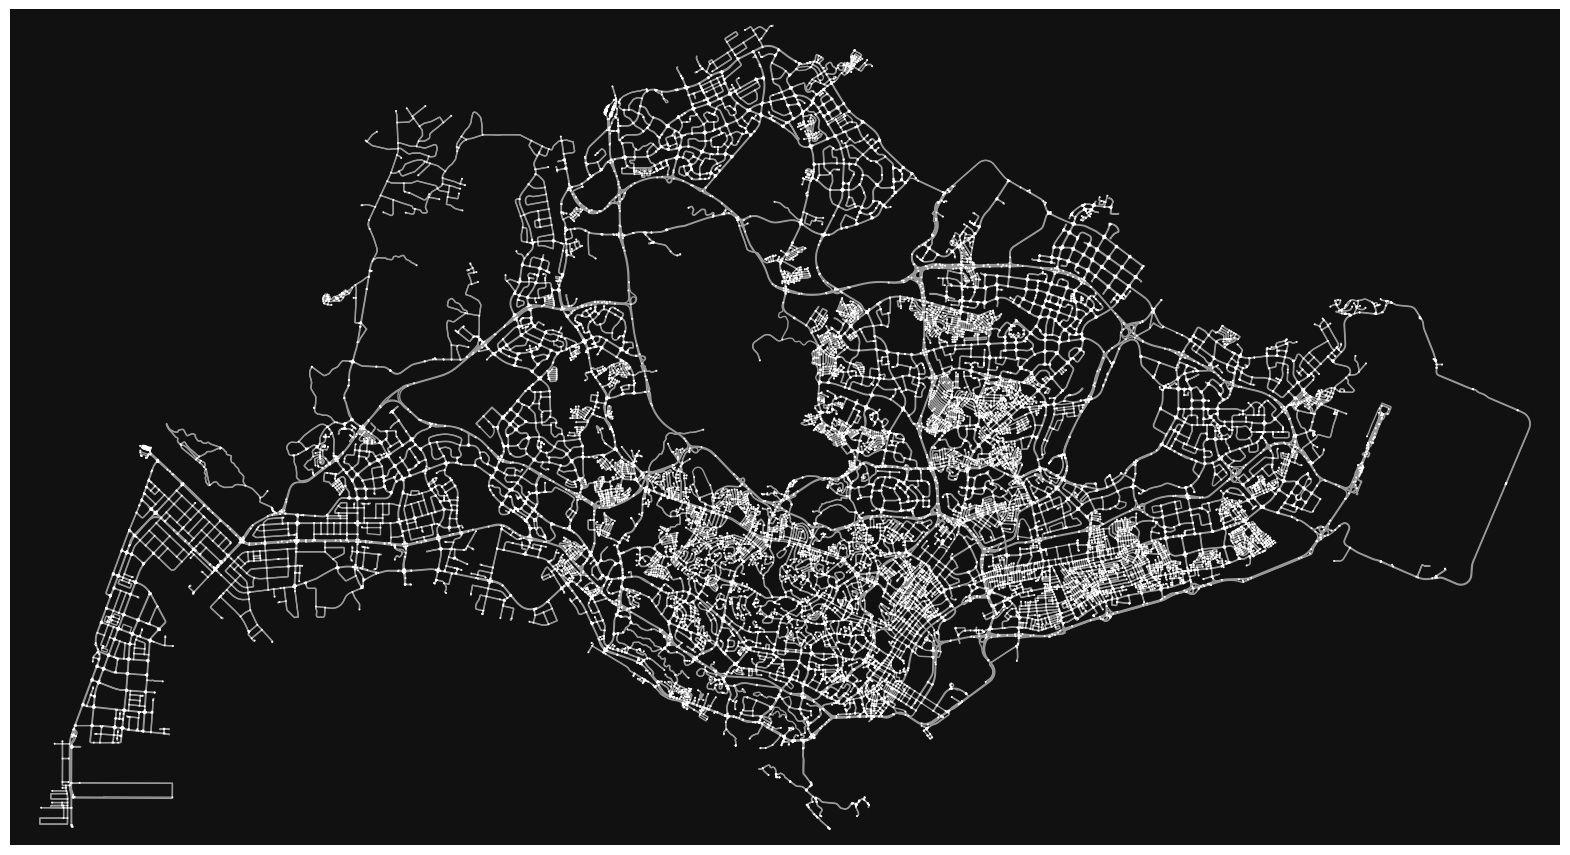

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

In [4]:
ox.plot_graph(G, ax=None, figsize=(20, 20), bgcolor='#111111', node_color='w', node_size=2, node_alpha=None, node_edgecolor='none', node_zorder=1, edge_color='#999999', edge_linewidth=1, edge_alpha=None, show=True, close=False, save=False, filepath=None, dpi=300, bbox=None)

In [5]:
ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)[0]

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
25451929,1.295232,103.872544,3,NaN,NaN,POINT (103.87254 1.29523)
25455287,1.295445,103.874004,3,14A,motorway_junction,POINT (103.87400 1.29544)
26777521,1.303979,103.823571,3,NaN,NaN,POINT (103.82357 1.30398)
26778779,1.304654,103.851530,3,NaN,NaN,POINT (103.85153 1.30465)
26778790,1.301522,103.850021,4,NaN,traffic_signals,POINT (103.85002 1.30152)
...,...,...,...,...,...,...
10170398180,1.315513,103.943323,4,NaN,NaN,POINT (103.94332 1.31551)
10170398182,1.315335,103.943243,1,NaN,NaN,POINT (103.94324 1.31533)
10170398183,1.315580,103.943303,3,NaN,NaN,POINT (103.94330 1.31558)


In [6]:
import requests

# Initialize an empty list to store valid postal codes
valid_postal_codes = []

# Start an interactive session
while True:
    user_input_postal = input("Enter postal code (or type 'done' to finish): ")

    # Check if the user wants to end the session
    if user_input_postal.lower() == 'done':
        break

    try:
        # Try to convert the input to an integer
        postal_code = int(user_input_postal)

        # Check if the integer has exactly 6 digits
        if 100000 <= postal_code <= 999999:
            valid_postal_codes.append(postal_code)
        else:
            print("Invalid postal code. It should have exactly 6 digits.")

    except ValueError:
        print("Invalid input. Please enter a valid integer.")

# Display the collected valid postal codes
print("Collected Postal Codes:", valid_postal_codes)


Collected Postal Codes: [310011, 750130, 730552, 120716, 320015]


In [7]:
import requests
import pandas as pd

# Initialize an empty list to store data
data_list = []

# Iterate through valid_postal_codes
for postal_code in valid_postal_codes:
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={postal_code}&returnGeom=Y&getAddrDetails=N"
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the response content as JSON
        result = response.json()['results'][0]

        # Extract relevant information
        latitude = result['LATITUDE']
        longitude = result['LONGITUDE']

        # Append data to the list
        data_list.append({'PostalCode': postal_code, 'Latitude': float(latitude), 'Longitude': float(longitude)})
    else:
        print(f"Request failed for postal code {postal_code} with status code {response.status_code}: {response.text}")

# Create a DataFrame from the collected data
query_database = pd.DataFrame(data_list)

# Display the DataFrame
print(query_database)


   PostalCode  Latitude   Longitude
0      310011  1.337233  103.858841
1      750130  1.444464  103.831776
2      730552  1.431857  103.795306
3      120716  1.302410  103.762805
4      320015  1.324471  103.861937


In [8]:
# Extract node data
nodes = ox.graph_to_gdfs(G, edges=False)

# Display the DataFrame containing node data
node_id = nodes[['x', 'y']]
node_id_df = node_id.reset_index()
node_id_df


,osmid,x,y
0,25451929,103.872544,1.295232
1,25455287,103.874004,1.295445
2,26777521,103.823571,1.303979
3,26778779,103.851530,1.304654
4,26778790,103.850021,1.301522
...,...,...,...
23873,10170398180,103.943323,1.315513
23874,10170398182,103.943243,1.315335
23875,10170398183,103.943303,1.315580
23876,10732302222,103.906146,1.305970


In [ ]:
def find_closest_row(node_id_df, x_val, y_val):
    # Calculate the Euclidean distance between each row's (x, y) and the given values
    node_id_df['distance'] = ((node_id_df['x'] - x_val) ** 2 + (node_id_df['y'] - y_val) ** 2) ** 0.5

    # Find the index of the row with the minimum distance
    closest_row_index = node_id_df['distance'].idxmin()

    # Get the row using the index
    closest_row = node_id_df.loc[closest_row_index]

    # Drop the distance column if you don't need it in the result
    closest_row = closest_row.drop('distance')

    return closest_row


In [145]:
import pandas as pd

# Assuming query_database and node_id_df are your DataFrames

result_list = []

for index, rows in query_database.iterrows():
    postal_code = rows["PostalCode"]
    x_val = rows["Longitude"]
    y_val = rows["Latitude"]

    result_row = find_closest_row(node_id_df, x_val, y_val)
    # Append data to the result_list for each iteration
    result_list.append([result_row["osmid"], postal_code, x_val, y_val])

# Create a DataFrame from the result_list
columns = ["osmid", "PostalCode", "Longitude", "Latitude"]
result_df = pd.DataFrame(result_list, columns=columns)

# Display the resulting DataFrame
result_df


,osmid,PostalCode,Longitude,Latitude
0,7.384225e+09,310011.0,103.858841,1.337233
1,4.602353e+09,750130.0,103.831776,1.444464
2,2.444955e+08,730552.0,103.795306,1.431857
3,1.218554e+09,120716.0,103.762805,1.302410
4,5.204064e+09,320015.0,103.861937,1.324471


In [91]:
result_df["osmid"][0]

7384225390.0

In [ ]:
for index, rows in result_df.iterrows():


In [146]:
from itertools import permutations

# Keep the first and last elements fixed, permutate the rest
middle_permutations = list(permutations(result_df["osmid"]))
middle_permutations

# Filter permutations that start at 0 and end at 5
filtered_permutations = [perm for perm in middle_permutations if perm[0] == result_df["osmid"][0] and perm[-1] == result_df["osmid"][4]]

route_distance_list = {}

for possible_routes in filtered_permutations:
    #print(possible_routes,len(possible_routes))
    for index in range(len(possible_routes)-1):
        #print(possible_routes[index])
        route = ox.routing.shortest_path(G,possible_routes[index],possible_routes[index+1],weight='length')
        full_route = ox.utils_graph.route_to_gdf(G, route)
        length_of_full_route = full_route["length"].sum()
        route_distance_list[possible_routes]=length_of_full_route

best_route = min(route_distance_list, key=lambda k: route_distance_list[k])


# Create a DataFrame with keys for merging
keys_df = pd.DataFrame({"osmid": best_route})

# Merge to get the corresponding information in the specified order
final_df = pd.merge(keys_df, result_df, on="osmid")

final_df = final_df.reset_index()


In [ ]:
1

In [148]:
[310011, 750130, 730552, 120716, 320015]

[310011, 750130, 730552, 120716, 320015]

In [153]:
import requests

# Initialize an empty list to store valid postal codes
valid_postal_codes = []

# Start an interactive session
while True:
    user_input_postal = input("Enter postal code (or type 'done' to finish): ")

    # Check if the user wants to end the session
    if user_input_postal.lower() == 'done':
        break

    try:
        # Try to convert the input to an integer
        postal_code = int(user_input_postal)

        # Check if the integer has exactly 6 digits
        if 100000 <= postal_code <= 999999:
            valid_postal_codes.append(postal_code)
        else:
            print("Invalid postal code. It should have exactly 6 digits.")

    except ValueError:
        print("Invalid input. Please enter a valid integer.")

# Display the collected valid postal codes
print("Collected Postal Codes:", valid_postal_codes)


import requests
import pandas as pd

# Initialize an empty list to store data
data_list = []

# Iterate through valid_postal_codes
for postal_code in valid_postal_codes:
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={postal_code}&returnGeom=Y&getAddrDetails=N"
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the response content as JSON
        result = response.json()['results'][0]

        # Extract relevant information
        latitude = result['LATITUDE']
        longitude = result['LONGITUDE']

        # Append data to the list
        data_list.append({'PostalCode': postal_code, 'Latitude': float(latitude), 'Longitude': float(longitude)})
    else:
        print(f"Request failed for postal code {postal_code} with status code {response.status_code}: {response.text}")

# Create a DataFrame from the collected data
query_database = pd.DataFrame(data_list)

# Display the DataFrame
print(query_database)



import pandas as pd

# Assuming query_database and node_id_df are your DataFrames

result_list = []

for index, rows in query_database.iterrows():
    postal_code = rows["PostalCode"]
    x_val = rows["Longitude"]
    y_val = rows["Latitude"]

    result_row = find_closest_row(node_id_df, x_val, y_val)
    # Append data to the result_list for each iteration
    result_list.append([result_row["osmid"], postal_code, x_val, y_val])

# Create a DataFrame from the result_list
columns = ["osmid", "PostalCode", "Longitude", "Latitude"]
result_df = pd.DataFrame(result_list, columns=columns)

# Display the resulting DataFrame
result_df


from itertools import permutations

# Keep the first and last elements fixed, permutate the rest
middle_permutations = list(permutations(result_df["osmid"]))
middle_permutations

# Filter permutations that start at 0 and end at 5
filtered_permutations = [perm for perm in middle_permutations if perm[0] == result_df["osmid"][0] and perm[-1] == result_df["osmid"][4]]

route_distance_list = {}

for possible_routes in filtered_permutations:
    #print(possible_routes,len(possible_routes))
    for index in range(len(possible_routes)-1):
        #print(possible_routes[index])
        route = ox.routing.shortest_path(G,possible_routes[index],possible_routes[index+1],weight='length')
        full_route = ox.utils_graph.route_to_gdf(G, route)
        length_of_full_route = full_route["length"].sum()
        route_distance_list[possible_routes]=length_of_full_route

best_route = min(route_distance_list, key=lambda k: route_distance_list[k])


# Create a DataFrame with keys for merging
keys_df = pd.DataFrame({"osmid": best_route})

# Merge to get the corresponding information in the specified order
final_df = pd.merge(keys_df, result_df, on="osmid")

final_df = final_df.reset_index()

# Create a folium map centered at the first location
map_center = [final_df["Latitude"].iloc[0], final_df["Longitude"].iloc[0]]
mymap = folium.Map(location=map_center, zoom_start=12)

# Add markers for each row in the DataFrame
for index, row in final_df.iterrows():
    icon_html = f"""<div style="font-family: courier new; color: white; background-color: blue; padding: 5px; border-radius: 5px;">{row['index']}</div>"""
    popup_html = f"Popup: {row['index']}"
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=folium.Popup(popup_html, max_width=3000),
        icon=folium.DivIcon(html=icon_html),
    ).add_to(mymap)

# Display the map
mymap

Collected Postal Codes: [310011, 750130, 730552, 120716, 320015]
   PostalCode  Latitude   Longitude
0      310011  1.337233  103.858841
1      750130  1.444464  103.831776
2      730552  1.431857  103.795306
3      120716  1.302410  103.762805
4      320015  1.324471  103.861937


In [ ]:
ox.plot.plot_graph_route(G,best_route, route_color='g', route_linewidth = 4,route_alpha= 0.5, orig_dest_size = 100)


In [128]:
best_route

(7384225390.0, 244495528.0, 1218554499.0, 4602352792.0, 5204064003.0)

,osmid,PostalCode,Longitude,Latitude
0,7.384225e+09,310011.0,103.858841,1.337233
1,2.444955e+08,730552.0,103.795306,1.431857
2,1.218554e+09,120716.0,103.762805,1.302410
3,4.602353e+09,750130.0,103.831776,1.444464
4,5.204064e+09,320015.0,103.861937,1.324471


In [ ]:
folium.Marker(location=[row['Latitude'], row['Longitude']], popup=row['PostalCode']).add_to(mapit)

In [110]:
a = result_df["osmid"][0]
b = result_df["osmid"][1]

In [111]:
#Epeed or Length
route = ox.routing.shortest_path(G,a,b,weight='speed')

In [114]:
# Calculate the length of the path
a = ox.utils_graph.route_to_gdf(G, route)
a["length"].sum()


18622.555999999997

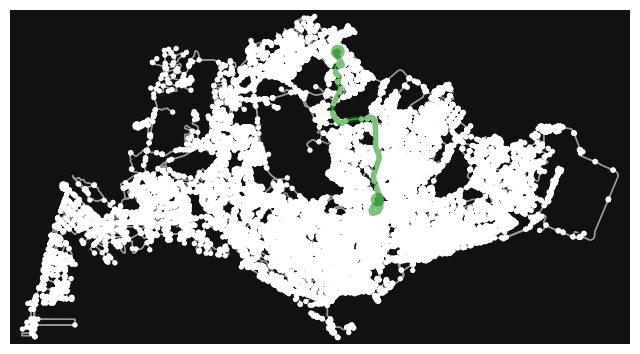

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [108]:
ox.plot.plot_graph_route(G,route, route_color='g', route_linewidth = 4,route_alpha= 0.5, orig_dest_size = 100)

18622.555999999997

In [35]:
import osmnx as ox

# Extract the edge lengths for the specified osmid ids
total_length = 0
for route_id in route:
    try:
        edge_data = G.edges[route_id]

        length = edge_data[0]['length']  # Assuming 'length' is a key in the edge attributes
        total_length += length

    except KeyError:
        print(f"Edge with route_id {route_id} not found in the network.")

print(f"Total length of edges for the given route_id ids: {total_length} meters")


TypeError: cannot unpack non-iterable numpy.float64 object

In [38]:
import osmnx as ox

# Extract the edge lengths for the specified osmid ids
total_length = 0
for index, route_id in enumerate(route):
    try:
        edge_data = G.edges[route_id]

        length = edge_data[0]['length']  # Assuming 'length' is a key in the edge attributes
        total_length += length

    except KeyError:
        print(f"Edge with route_id {route_id} not found in the network.")

print(f"Total length of edges for the given route_id ids: {total_length} meters")


ValueError: not enough values to unpack (expected 3, got 2)

In [45]:
route

[7384225390.0,
 7384178243,
 7672836325,
 1446899953,
 4724907196,
 6307500219,
 1446899948,
 5284718089,
 4774654571,
 239934388,
 239934510,
 245170955,
 245170948,
 2509900470,
 439986670,
 2509968094,
 439986651,
 4591891508,
 4598764083,
 243418578,
 4591891498,
 4935012075,
 498793373,
 4591897641,
 243423319,
 4593195692,
 243423341,
 4591909316,
 243423448,
 242931421,
 4591909317,
 4599034811,
 242931402,
 4599034796,
 242931400,
 229064735,
 206098237,
 435824986,
 4598978357,
 7168429965,
 6270824636,
 436773045,
 436773046,
 231867442,
 231863933,
 436773049,
 243688405,
 240408141,
 240407505,
 4593449043,
 247745507,
 437138891,
 240407497,
 240407900,
 4427352167,
 440556702,
 244893866,
 1781541228,
 440556700,
 244893872,
 1855321534,
 1855321546,
 3521322095,
 4580398881,
 244893917,
 244893887,
 3521322112,
 11459876358,
 244893859,
 4600583848,
 4600486010,
 4600486035,
 244893875,
 4600486011,
 4600689527,
 244893860,
 244919173,
 4594224456,
 4594224451,
 46023987

In [56]:
len(route)

96

In [11]:
for index, row in query_database.iterrows():
    print(index)
    if index == 0:
        mapit = folium.Map(location=[row['Latitude'], row['Longitude']], zoom_start=15)
        folium.Marker(location=[row['Latitude'], row['Longitude']], popup=row['PostalCode']).add_to(mapit)

    else:
    # Add marker to the map
        folium.Marker(location=[row['Latitude'], row['Longitude']], popup=row['PostalCode']).add_to(mapit)

mapit

0
1
2
3
4
